In [40]:
import pickle
import pandas as pd
import numpy as np
import os
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import string
from dateutil.parser import parse

In [5]:
def prettify_domain(x):
    if x == 'nyt':
        return 'New York Times'
    elif x == 'mj':
        return 'Mother Jones'
    elif x == 'cs_monitor':
        return 'Christian Science Monitor'
    elif x == 'guardian_us':
        return 'Guardian (US)'
    elif x == 'wapo':
        return 'Washington Post'
    elif x == 'https://shotofprevention/':
        return 'Shot of Prevention'
    elif x == 'nat_review':
        return 'National Review'
    elif x == 'chd':
        return "Children's Health Defense"
    elif x == 'pj':
        return 'PJ Media'
    elif x == 'nation':
        return 'The Nation'
    elif x == 'dem_now':
        return 'Democracy Now'
    elif x == 'usa_today':
        return 'USA Today'
    elif x == 'https://www.voicesforvaccines.org/blog/':
        return 'Voices for Vaccines'
    elif x == 'cns':
        return 'CNS'
    elif x == 'nbc':
        return 'NBC'
    elif x == 'https://www.citizens.org/':
        return 'Citizens'
    elif x == 'inthesetimes':
        return 'In These Times'
    elif x == 'activistpost':
        return 'Activist Post'
    elif x == 'https://adultvaccinesnow.org/blog/':
        return 'Adult Vaccines Now'
    elif x == 'newswithviews':
        return 'News With Views'
    elif x == 'sonsoflibertymedia':
        return 'Sons of Liberty Media'
    elif x == 'libertyunyielding':
        return 'Liberty Unyielding'
    elif x == 'conservativedailynews':
        return 'Conservative Daily News'
    elif x == 'https://immunizationevidence.org/featured_issues/':
        return 'Immunization Evidence'
    elif x == 'conservativefiringline':
        return 'Conservative Firing Line'
    elif x == 'progressivestoday':
        return 'Progressives Today'
    elif x == 'independentsentinel':
        return 'Independent Sentinel'
    elif x == 'https://physiciansforinformedconsent.org/':
        return 'Physicians for Informed Consent'
    elif x == 'charismanews':
        return 'Charisma News'
    elif x == 'cbn':
        return 'CBN'
    else:
        return ' '.join([w.capitalize() for w in x.split('_')]).strip()

In [16]:
def reorderLegend(ax=None,order=None,unique=False,loc='upper left',title=None,
          fontsize=18,title_fontsize=20):
    if ax is None: ax=plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0])) # sort both labels and handles by labels
    if order is not None: # Sort according to a given list (not necessarily complete)
        keys=dict(zip(order,range(len(order))))
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t,keys=keys: keys.get(t[0],np.inf)))
    if unique:  labels, handles= zip(*unique_everseen(zip(labels,handles), key = labels)) # Keep only the first of each handle
    ax.legend(handles, labels,loc=loc,title=title,
          fontsize=fontsize,title_fontsize=title_fontsize)
    return(handles, labels)


def unique_everseen(seq, key=None):
    seen = set()
    seen_add = seen.add
    return [x for x,k in zip(seq,key) if not (k in seen or seen_add(k))]

# Notebook for exploring basic stats of news article dataset.

In [55]:
dedup_combined_df = pd.read_csv('dedup_df.tsv',sep='\t',header=0,index_col=0)
dedup_combined_df.shape

(57757, 8)

In [56]:
dedup_combined_df = dedup_combined_df.loc[~pd.isnull(dedup_combined_df.date)].copy()
dedup_combined_df.shape

(55932, 8)

In [57]:
dedup_combined_df['year'] = [parse(d).year  
                             for d in dedup_combined_df.date]
dedup_combined_df['month'] = [parse(d).month  
                             for d in dedup_combined_df.date]

There are 41k unique articles, with 21.6k from R-wing news sources and 19.5k from L-wing news sources.

In [58]:
dedup_combined_df.stance.value_counts()

anti    35757
pro     20175
Name: stance, dtype: int64

We know that 1k are from the Associated Press.

In [59]:
dedup_combined_df.is_AP.value_counts()

False    14084
True      1063
Name: is_AP, dtype: int64

Articles from 7 outlets--The New York Times (L), Mother Jones (L), Breitbart (R), Fox (R), Washington Post (L), Forbes (R), and Christian Science Monitor (L)--make up about half the total volume of articles.

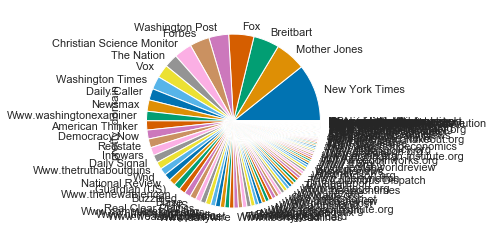

In [60]:
dedup_combined_df['pretty_domain'] = dedup_combined_df['domain'].apply(prettify_domain)
dedup_combined_df['pretty_domain'].value_counts().plot.pie()

In [51]:
dedup_combined_df.loc[dedup_combined_df.stance == 'anti']['pretty_domain'].value_counts()[:10]

Breitbart                 2682
Fox                       2618
Forbes                    2046
Washington Times          1358
Daily Caller              1191
Newsmax                   1178
Www.washingtonexaminer     983
American Thinker           958
Redstate                   915
Infowars                   853
Name: pretty_domain, dtype: int64

There is a steady increase in the number of articles covering CC from ~2008 onwards.

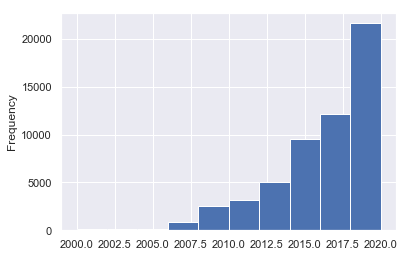

In [52]:
dedup_combined_df.loc[dedup_combined_df.year.isin(range(2000,2021))].year.plot.hist()

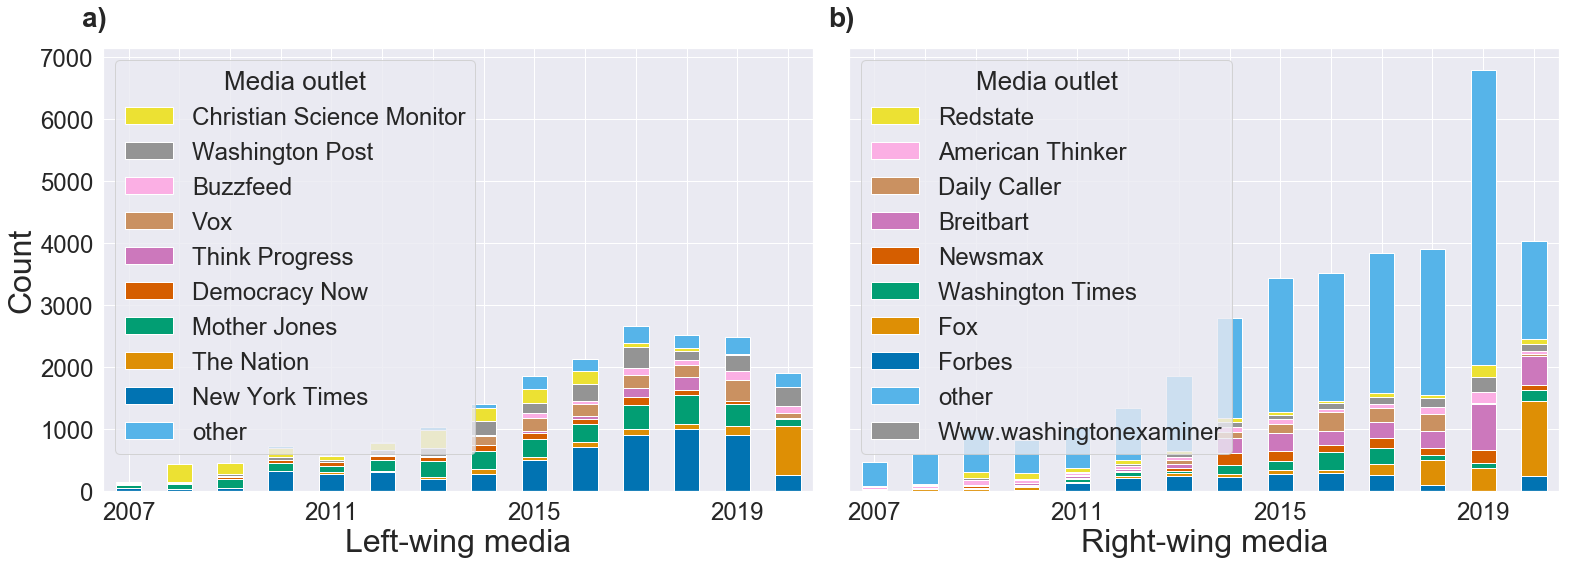

In [53]:
top_domains = {'pro':set(dedup_combined_df.loc[dedup_combined_df.stance == 'pro'].\
pretty_domain.value_counts().index[:9]),
               'anti':set(dedup_combined_df.loc[dedup_combined_df.stance == 'anti'].\
pretty_domain.value_counts().index[:9])}

dfs = {}
for side in ['pro','anti']:
    df = pd.DataFrame(columns=['outlet']+list(range(2007,2021)))
    for outlet in top_domains[side]:
        #print(outlet)
        row = [outlet]
        counts = dedup_combined_df.loc[dedup_combined_df.pretty_domain == outlet].year.value_counts()
        row.extend([counts[int(c)] if c in counts else 0 for c in range(2007,2021)])
        row_df = pd.DataFrame(row).T
        row_df.columns = df.columns
        df = df.append(row_df,
                       ignore_index=True)
    row = ['other']
    counts = dedup_combined_df.loc[(dedup_combined_df.stance == side) & 
                             (~dedup_combined_df.pretty_domain.isin(top_domains[side]))].year.value_counts()
    row.extend([counts[int(c)] if c in counts else 0 for c in range(2007,2021)])
    row_df = pd.DataFrame(row).T
    row_df.columns = df.columns
    dfs[side] = df.append(row_df,
                   ignore_index=True)

sns.set_palette('colorblind')
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(22,8),sharey=True)
dfs['pro'].set_index('outlet').T.plot(kind='bar', stacked=True, fontsize=24,ax=ax1)
dfs['anti'].set_index('outlet').T.plot(kind='bar', stacked=True, fontsize=24,ax=ax2)
ax1.set_ylabel('Count',fontsize=32)
ax2.set_ylabel('')
ax1.set_xlabel('Left-wing media',fontsize=32)
ax2.set_xlabel('Right-wing media',fontsize=32)
ax1.set_xticklabels(rotation=0,labels=range(2007,2021))
ax2.set_xticklabels(rotation=0,labels=range(2007,2021))
n = 4
for ax in [ax1,ax2]:
    [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
ax1.legend()
handles, labels = ax1.get_legend_handles_labels()
reorderLegend(ax1,['Christian Science Monitor','Washington Post','Buzzfeed','Vox','Think Progress',
                'Democracy Now','Mother Jones','The Nation','New York Times','other'],
             title='Media outlet',fontsize=24,title_fontsize=26)
ax2.legend()
handles, labels = ax2.get_legend_handles_labels()
reorderLegend(ax2,['Redstate','American Thinker',
'Daily Caller','Breitbart','Newsmax','Infowars',
'Washington Times','Fox','Forbes','other'],
             title='Media outlet',fontsize=24,title_fontsize=26)

for n, ax in enumerate([ax1,ax2]):  
    ax.text(-0.03, 1.05, '{})'.format(string.ascii_lowercase[n]), transform=ax.transAxes, 
            size=28, weight='bold')
plt.tight_layout()

In [54]:
len(dedup_combined_df.domain.value_counts())

123